__In this notebook, I'm following along with Chapter 4 of Hands-On Machine Learning (O'Reilly) ([Notebook](https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb)).__ 

We want to make the transition from using ML algorithms like black boxes, to more deeply understanding what's happening under the hood. This will allow us to:
- Hone in on the appropriate model, training algorithm, and hyperparameters. 
- Debug issues and perform error analysis more efficiently. 
- Build and train neural networks. 

We'll start by looking at Linear Regression, and two different ways to train it:
- Using a "closed-form" equation
- Using "Gradient Descent"

We'll also look at Polynomial Regression, a more complex model that can fit nonlinear datasets. Since this model has more parameters, it's more prone to overfitting, so we'll look at how to detect whether or not we're overfitting using learning curves in addition to regularization techniques that can reduce this risk. 

Finally, we'll look at two more models typically used for classification tasks:
- Logistic Regression
- Softmax Regression 

# Linear Regression
Below is the basic form of a Linear Regression model, and subsequently rewritten in vectorized form. 

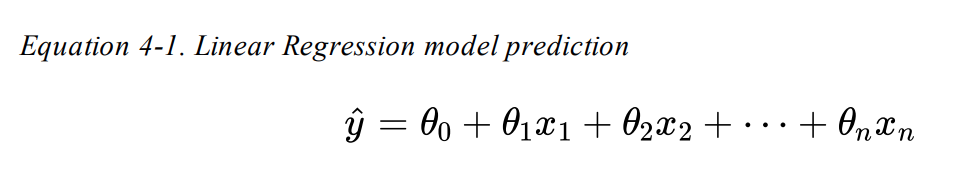

In [1]:
import IPython.display as display
display.Image('figures/linear_regression_basic.png')

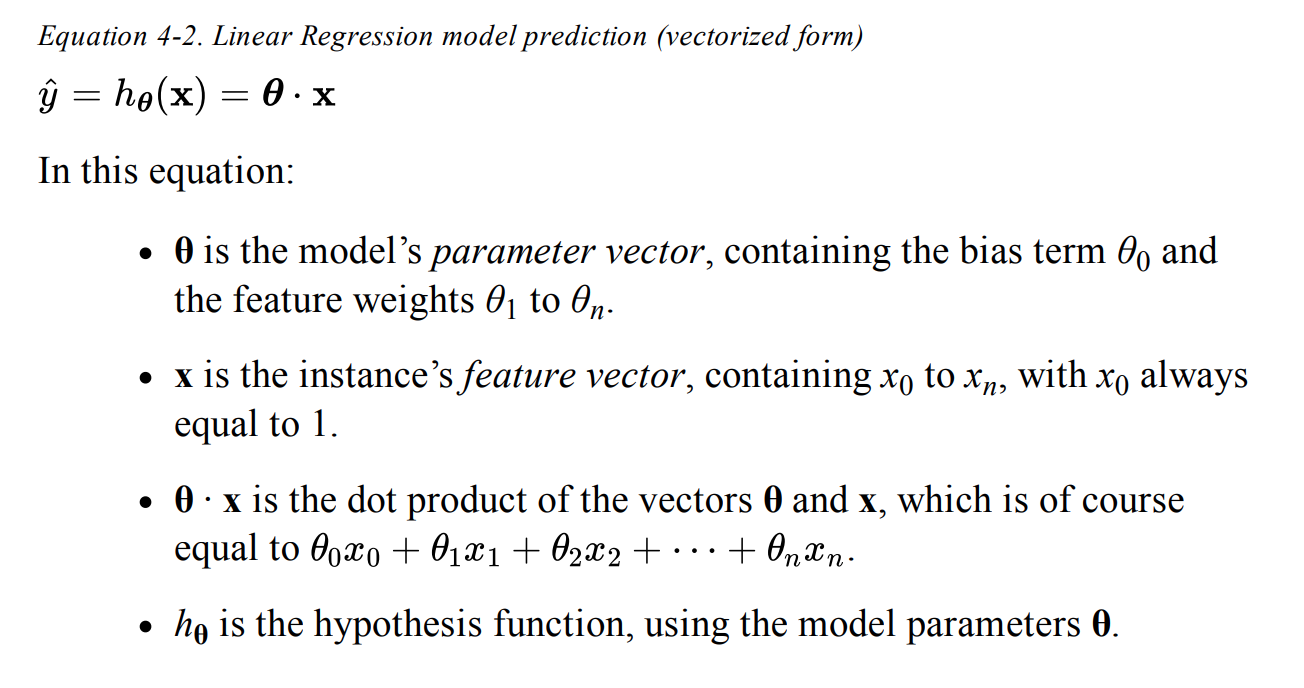

In [2]:
display.Image('figures/linear_regression_vectorized.png')

To train this model, we need of a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is Root Mean Square Error (RMSE). So, we need to find a value of theta that minimizes RMSE. In practice, it's easier to minimize just MSE and it yields the same result (because minimizing a function also minimizes its square root). 

The MSE of a Linear Regression hypothesis: 

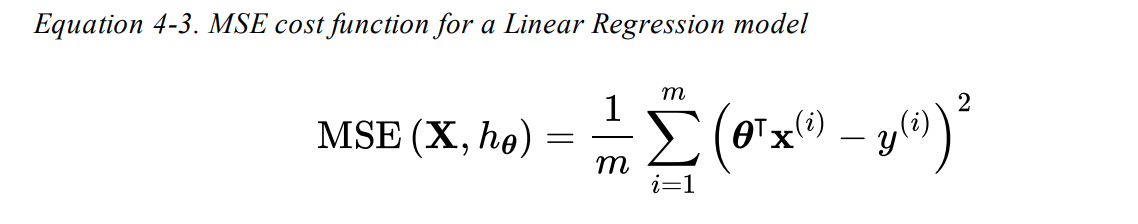

In [3]:
display.Image('figures/mse.png')

## The Normal Equation
To find the value of theta that minimizes our cost function, we can use a _closed-form solution_. This is called the _Normal Equation_. 

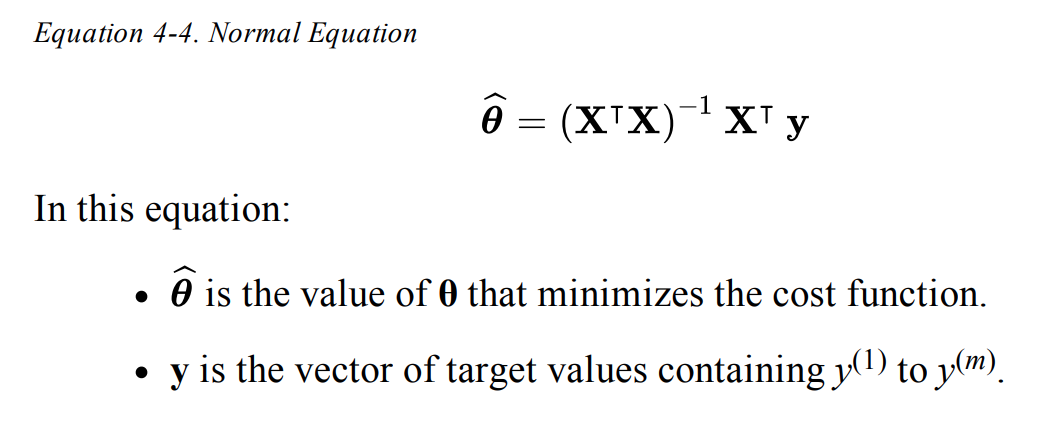

In [4]:
display.Image('figures/normal_equation.png')

In [5]:
# Generate linear-looking data to test Normal Equation
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

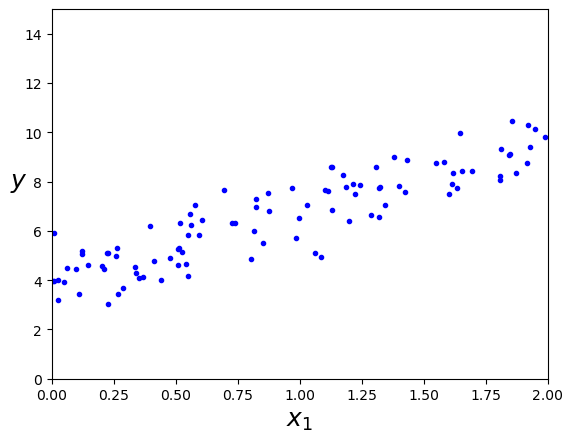

In [6]:
import matplotlib.pyplot as plt
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# Compute optimal theta using Normal Equation

# Add vector of ones to feature vector to account for intercept (theta-0)
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.98033297],
       [2.82285401]])

The noise we added made it impossible to recover the exact parameters (intercept = 4, theta = 3), but we got pretty close. 

In [8]:
# Make predictions 
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict 

array([[3.98033297],
       [9.62604099]])

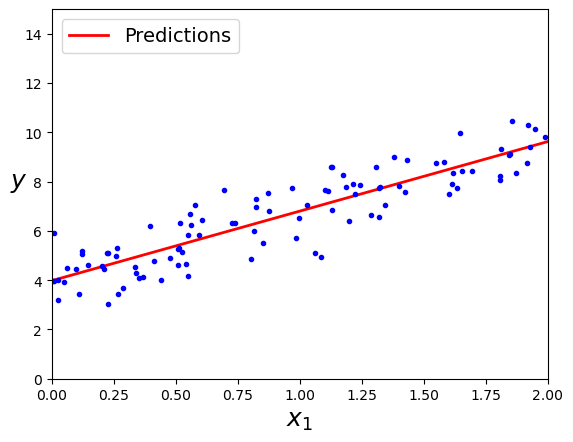

In [9]:
# Plot predictions
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [10]:
# We can accomplish this more simply using LinearRegression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.98033297]), array([[2.82285401]]))

In [11]:
lin_reg.predict(X_new)

array([[3.98033297],
       [9.62604099]])

## Computational Complexity
The Normal Equation calculates the inverse of `(X-transpose * X)`, which is an `(n+1) x (n+1)` matrix (`n` being the number of features). The computational complexity of inverting such a matrix is about `O(n^2.4)` to `O(n^3)`. This means if you were to double the amount of features, the computation time would go up max by a factor of 8. 

`LinearRegression` uses an approach to calculate the inverse called _Singular Value Decomposition_ (SVD) that is quite involved and not so relevant to this notebook. However, the time complexity here is `O(n^2)`, so doubling the number of features would increase the computation time by about 4. 

# Gradient Descent
This is a very different way of training a Linear Regression model, which is better suited for cases where there's a large number of features or training instances. It is a generic optimization algorithm applicable to many types of problems. Generally, the idea is to tweak parameters iteratively to minimize a cost function. 

We start with _random initialization_, randomly assigning values to each coefficient theta. We then improve the model gradually by choosing new nearby values (in the direction of a minimum) to decrease the cost function. Eventually, the algorithm converges to a minimum. 

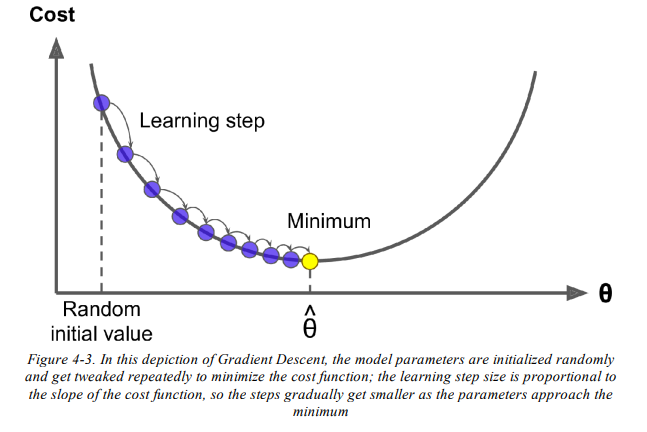

In [12]:
display.Image('figures/gradient_descent.png')

An important part of the Gradient Descent algorithm is our choice of the _learning rate_ parameter, which determines the size of the steps we take. If those steps are too small, it'll take a while to converge and model training will take longer. 

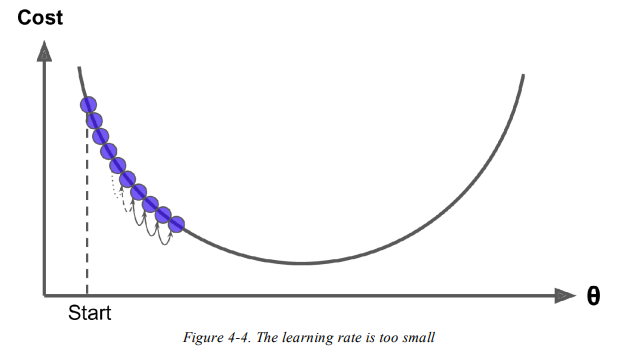

In [13]:
display.Image('figures/learning_rate_small.png')

However, if the leraning rate is too high, we might "jump across the valley" and end up with a higher cost than we had before. Sometimes, the algorithm can "diverge" with higher and higher costs, and a good solution will never be found. 

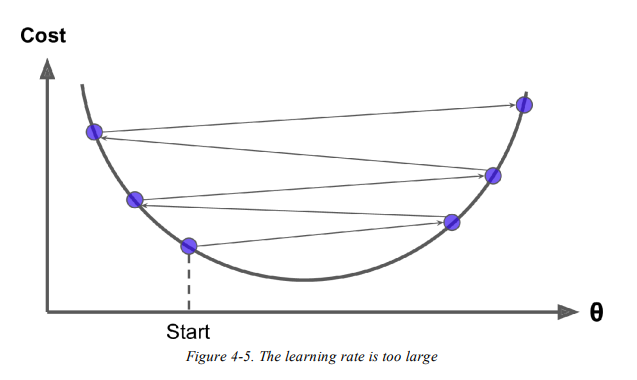

In [14]:
display.Image('figures/learning_rate_big.png')

Finally, not all cost functions look like nice, regular bowls. In these situations, it is possible to converge to a local minimum but not a global minimum, meaning the cost function is not actually minimized and the optimal solution isn't found. 

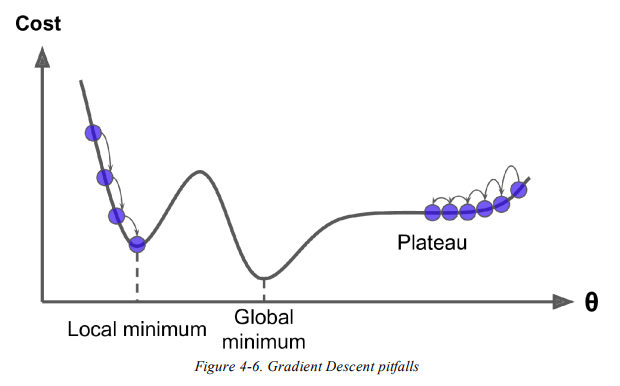

In [15]:
display.Image('figures/irregular_cost.png')

Fortunately, the MSE cost function for a Linear Regression moel is a _convex function_, meaning if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies there are no local minima, just one global minimum. Also, it is a continuous function with no extreme changes in slope. 

This all means: __Gradient Descent for Linear Regression using MSE is guaranteed to approach arbitrarily close the global minimum.__ 
- The cost function has the shape of a bowl. As an example, if a model has two features with very different scales, the bowl will be elongated. 
- This is why feature scaling is so important when using Gradient Descent. To find an optimal solution with features on different scales takes longer. You can the `StandardScaler` class. 
- The more feaures we have, the more parameters we have. And the more parameters we have, the larger our _parameter space_ is, meaning Gradient Descent has to check more combinations of model parameters until it finds an optimal solution. The example below is simply two-dimensional (two parameters), but imagine a model with 300 parameters. This would result in a 300-dimensional parameter space. 

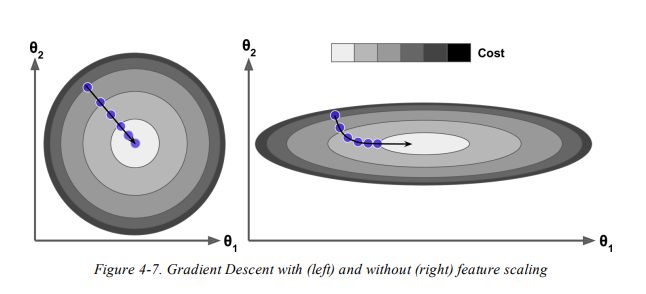

In [16]:
display.Image('figures/cost_bowl.png')

## Batch Gradient Descent
To implement gradient descent, we need to calculate the gradient of the cost function with regard to each model parameter (partial derivatives). 

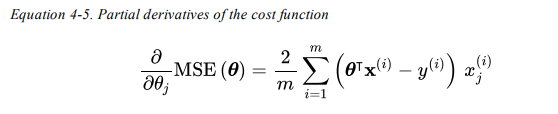

In [17]:
display.Image('figures/partial_derivatives.png')

Instead of computing them individually, you can calculate them all in one go using the equation below. This yields the the _gradient vector_, which contains all partial derivatives of the cost function. 

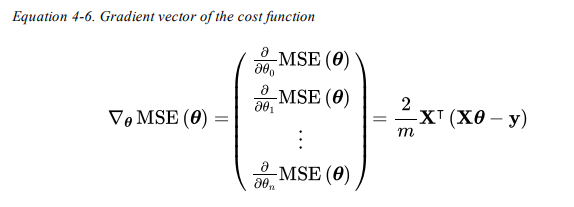

In [18]:
display.Image('figures/gradient_vector.png')

Notice how this formula involves calculations over the full training set __X__. That's why this is called _Batch Gradient Descent_, because it uses the entire _batch_ of training data at every step, meaning it's very slow on large training sets. However, its performance on Linear Regression models with large numbers of features (e.g. hundreds of thousands) is still better than using the Normal Equation or SVD. 

Once we have the gradient vector, we go in the _opposite direction_ of the gradient (for each parameter). The size of this step is defined by our learning rate.  

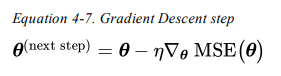

In [19]:
display.Image('figures/learning_rate.png')

In [20]:
# Implementation 

eta = 0.1 # Learning rate 
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # Random initialization 

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [21]:
theta

array([[3.98033297],
       [2.82285401]])

In [22]:
# Implement w multiple learning rates 

theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

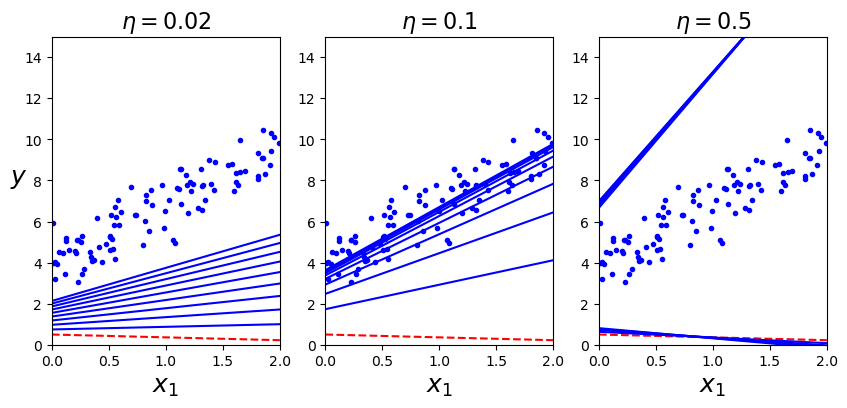

In [23]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## Stochastic Gradient Descent
Unlike Batch Gradient Descent which uses the entire training set at each iteration, _Stochastic_ Gradient Descent uses only a _single_ (random) training instance at each iteration. This means it's much faster, and can be used to train on huge training sets more easily. 

However, because it's random, Stochastic GD is much less regular than Batch GD. Instead of gently reaching the minimum of the cost function, Stochastic GD bounces around a lot (decreases only on average) until it reaches approximately the minimum, at which point it continues to bounce around. When the algorithm stops, the parameters values are good but not optimal. 

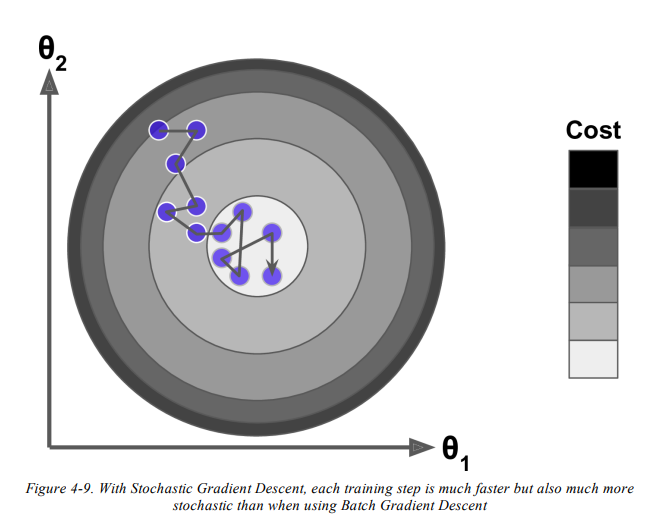

In [24]:
display.Image('figures/stochastic_gd.png')

This irregularity can actually be a benefit, because the algorithm more easily jumps out of local minima. Stochastic GD actually has a better chance of finding a global minimum than Batch GD. 

To balance the costs (not optimal solution) and benefits (escape local minima) of Stochastic GD, we can implement a _learning schedule_ that gradually reduces the learning rate. The steps start out larger, and gradually get smaller as it approaches a global minimum. 

If the learning rate is reduced to quickly, you can get stuck at a local minimum. And too slowly, you may jump around the minimum for a long time without ever finding an optimal solution if training is stopped too early.  

In [25]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

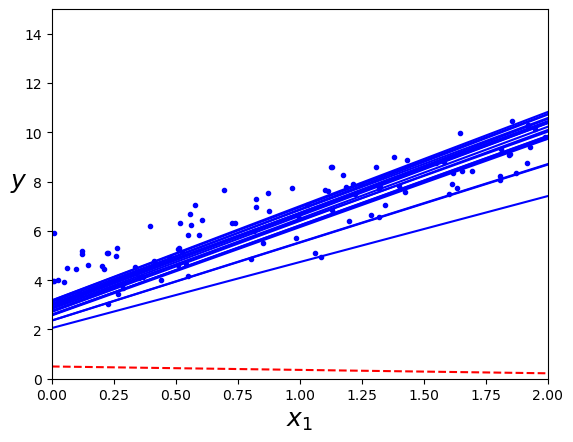

In [26]:
# Stochastic GD implementation 
n_epochs = 50
t0, t1 = 5, 50 # Learning schedule hyperparameters 

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # Random initialization 

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)   

plt.plot(X, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                               
plt.show()                                           

Conventionally, we iterate by rounds of _m_ iterations. Each round is called an _epoch_. While Batch GD iterated 1,000 times through the whole training set, Stochastic GD (in this example) only goes through the whole training set 50 times and gets a decent solution nonetheless. 

In [27]:
theta

array([[3.98434188],
       [2.8464661 ]])

Note that since instances are picked randomly, some instances may be picked several times in a single epoch, while others may not be picked at all. If you want to guarantee that all training instances are used at each epoch, you can shuffle the training set and go through instance by instance, and then shuffle again for the next epoch (and so on). This approach generally converges more slowly. 
- It's very important that the instances are actually randomly picked or shuffled for each epoch. If, for example, the instances are sorted by label (y-value), then SGD will start by optimizing for one label, then the next, and so on. This won't settle close to the global minimum. 

We can use the `SGDRegressor` class to run Stochastic GD. Here, we run for a maximum of 1,000 epochs or until the loss drops by less than 0.001 during one epoch. We start with a learning rate of 0.1. No regularization is used. 

In [28]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [29]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.96813484]), array([2.80603007]))

## Mini-Batch Gradient Descent
Instead of computing gradients using the entire dataset (Batch) or just a single training instance (Stochastic), Mini-Batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of Mini-Batch over Stochastic is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs. 

Compared to Stochastic GD, Mini-Batch GD will be less erratic and get a bit closer to the minimum, especially with fairly large mini-batches. However, Mini-Batch GD is more likely than Stochastic GD to get stuck at local minima (which isn't a problem to consider with Linear Regression). While Batch GD might might take a less circuitous path to the minimum, it is significantly slower. If you use a good learning schedule, Stochastic GD and Mini-Batch GD will reach the minimum. 

In [30]:
# Implement mini-batch 
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [31]:
theta

array([[4.08633422],
       [2.91842861]])

In [32]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

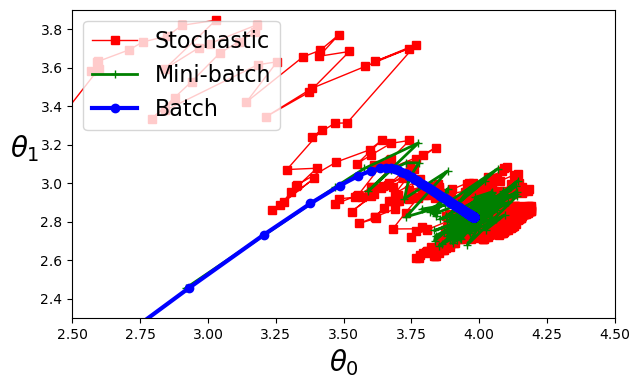

In [33]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

It's important to note there is almost no difference between these algorithms after training. They all end up with very similar models and make predictions in the same way. 

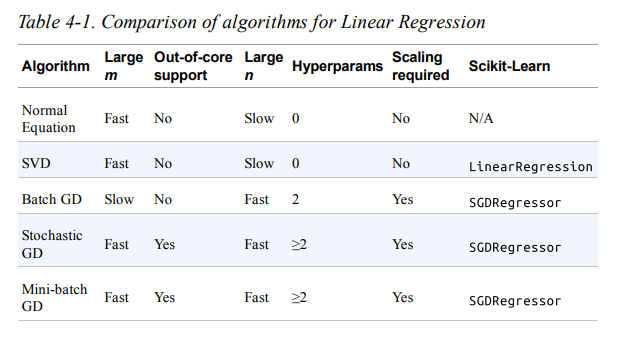

In [34]:
display.Image('figures/linreg_algo_comparison.png')

# Polynomial Regression
If your data is more complex than a straight line, you can still use a linear model to make predictions. A simple way to do this is adding powers of each feature as new features, and training a linear model on this expanded set of features. This is _Polynomial Regression_. 

In [35]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

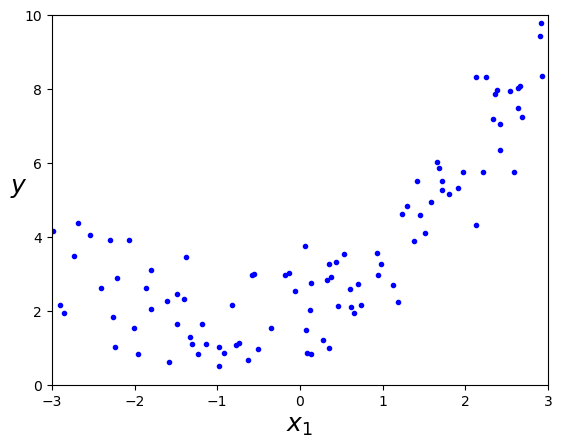

In [36]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

It's clear a straight line will never fit this data, so we can use the `PolynomialFeatures` class to transform our training data, adding the square of each feature as a new feature. In our case, we only have one feature to start. 

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.38942838]), array([2.38942838, 5.709368  ]))

In [40]:
# Fit LinearRegression using polynomial data
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

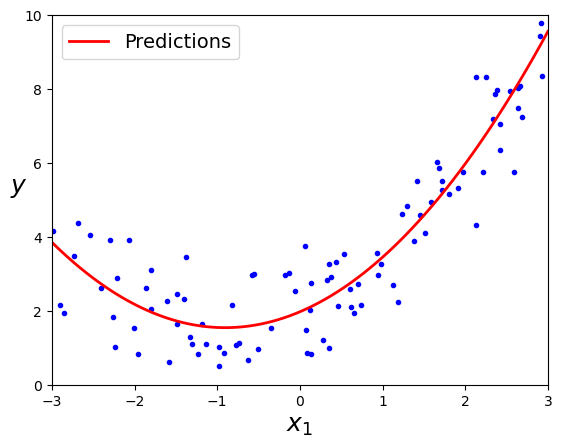

In [41]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

We weren't too far off from our original function (`y = 0.5x^2 + 1.0x + 2 + noise`). Our model estimates `y_hat = 0.53x^2 + 0.95x + 1.97` (might change marginally on further reruns). 

Note that if there are multiple features, Polynomial Regression is also capable of finding relationships between features. This is possible because the `PolynomialFeatures` class also adds _combinations_ (multiplicative) of all features up to the given degree. E.g. imagine two features _a_ and _b_. `PolynomialFeatures` would create _ab, a^2b, ab^2_ in addition to _a2, a^3, b^2, b^3_. 

Be careful, as `PolynomialFeatures` can quickly create massive feature datasets through combination of all existing features and their higher orders. 

# Learning Curves
If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with simple Linear Regression (keep in mind overfitting). Below we'll fit a 300-degree polynomial model to the training data and compare it to a pure linear model and a quadratic model. The 300-degree model wiggles around to get as close as possible to the training instances. 

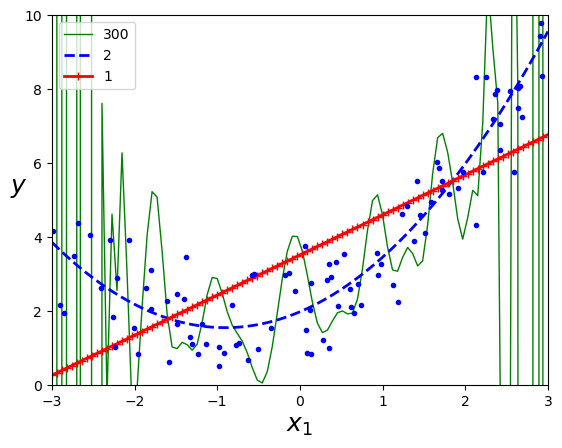

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
    
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

It's obvious that the 300-degree model is severely overfitting the training data. And we can be so certain of this because we know that the underlying function is quadratic. However, we don't normally know the underlying function, so how can we determine how complex our model should be? How do we know if we're underfitting or overfitting? 

In Ch. 2 we used cross-validation to answer this question: 
- If the model performs well on training data, but poorly on validation data, then we're overfitting. 
- If the model performs poorly on both, then we're underfitting. 

We can also look at _learning curves_: plots of the model's performance on the training set and validation set as a function of the training set size (or the training iteration). We can define a function to train the model several times on different sized subsets of the training data. 

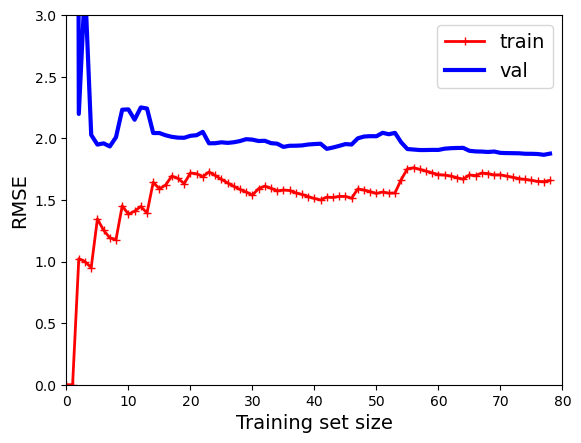

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)             
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                        
plt.show()                                     

Explanation of the above plot: 
- Validation: when there's only 1 (or very few) examples in the training set, the model can predict pretty much perfectly, which is why the RMSE is at (or close to) 0. However, as more training instances are added, it's impossible to fit the data perfectly. Remember, our data is not linear at all (plus there's noise) and we used a pure linear model. Eventually, the RMSE plateaus. 
- Training: when the model is trained on very few instances, it cannot generalize at all to new data, explaining why the RMSE is so high. As more data is added, model generalization improves and the RMSE lowers and eventually plateaus. Again, we're limited by the fact that our data is not actually linear. 

Both these learning curves are typical of a model that's underfitting. Both have reached a plateau and they're close/high. 

__Remember:__ if your model is underfitting, adding more training examples will not help. You need to use a more complex model or include better features. 

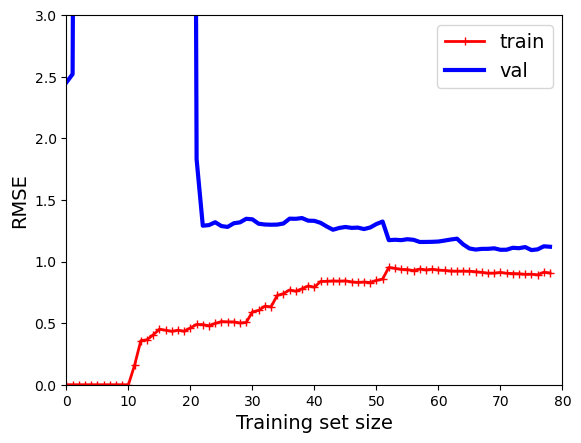

In [52]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)), 
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])  
plt.show()